# **주요 내용**

*   다중 입력 모델 구현간 가능한 방법은 2가지이다. 그 중에서도, 2번의 방법으로 우선 실험한다.

    1. pre-emphasis만 수행된 데이터를 raw audio data와 합쳐서 training
    2. pre-emphasis data와 raw audio data를 각각 훈련한 다음 결과를 연결하여 분류기 추가
*   모델 앙상블(essenble) 구현
*   모델 생성 및 평가에 대한 함수화
    *   https://github.com/KerasKorea/KEKOxTutorial/blob/master/16_Ensembling%20ConvNets%20using%20Keras.md

In [0]:
notebookName = "20200509"
notebookName

'20200509'

In [0]:
import tensorflow as tf
tf.__version__

'2.2.0-rc4'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1111607067204181819, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17197121545136306321
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7742939160552097747
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7304675328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4394280476276903618
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [0]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [0]:
!nvidia-smi

Sat May  9 06:46:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    24W /  75W |    203MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [0]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['GSM09752SCY0', 'GSF03031LJH0', 'GSF05134JHK0', 'GSM02544LHS0', 'GSF06833JYK0']
50


***.pcm to *.wav**

In [0]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    print("{}\t{}".format(i, folder_path))

    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

0	GSF03031LJH0
1	GSF03732JJH0
2	GSF04122LHK0
3	GSF04524CJI0
4	GSF04623LWJ0
5	GSF04923PEY0
6	GSF05134JHK0
7	GSF05432KSY0
8	GSF05733HBH0
9	GSF05844LJR0
10	GSF06654KES0
11	GSF06742CKA0
12	GSF06833JYK0
13	GSF06934SYN0
14	GSF07132LCY0
15	GSF08142LDH0
16	GSF08233NEH0
17	GSF08333KJH0
18	GSF09025WYY0
19	GSF09431SHY0
20	GSF09844KKS0
21	GSM02434AGS0
22	GSM02544LHS0
23	GSM03224CHD0
24	GSM03321SDK0
25	GSM03634SJY0
26	GSM03823YJK0
27	GSM04233KMS0
28	GSM04424JBRC
29	GSM05953CJH0
30	GSM06044JBY0
31	GSM06235BJH0
32	GSM07042NSK0
33	GSM07355MIW0
34	GSM09534JHD0
35	GSM09644KCK0
36	GSM09752SCY0
37	I4F02224SDY0
38	I4F02631KSM0
39	I4F02821YRR0
40	I4F02933JSI0
41	I4F03423KSR0
42	I4F03543KSY0
43	I4F03922LKY0
44	I4F04732OIY0
45	I4F05332CJH0
46	I4F05625JSY0
47	I4F07443LJA0
48	I4F07633JSI0
49	I4F07852PKJ0


In [0]:
import numpy as np

num_labels = 50
num_features = 100
data_length = 3 ** 9   # 19,683

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [0]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, data_length))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 19683), train_labels.shape: (4000,)
test_data.shape: (1000, 19683), test_labels.shape: (1000,)


**train data, validation data 분할 및 전처리 (normalization)**

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

random_state = 1234
test_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels,
                                                  test_size = test_size,
                                                  random_state = random_state) # fixed

x_train = X_train.reshape(len(X_train), data_length, 1)
x_val = X_val.reshape(len(X_val), data_length, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

In [0]:
print("test_size: {}, random_state: {}\n".format(test_size, random_state))
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

test_size: 0.2, random_state: 1234

x_train.shape: (3200, 19683, 1), y_train.shape: (3200, 50)
x_val.shape: (800, 19683, 1), y_val.shape: (800, 50)


**Build Model**

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

# define input layer
input_shape = x_train[0].shape
model_input = layers.Input(shape = input_shape, name = 'input')

In [0]:
def raw_audio_conv1d(model_name, model_input):
    x = layers.Conv1D(name = "x_block1_conv", filters = 16, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(model_input)
    x = layers.MaxPooling1D(name = "x_block1_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "x_block1_norm")(x)

    x = layers.Conv1D(name = "x_block2_conv", filters = 32, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(x)
    x = layers.MaxPooling1D(name = "x_block2_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "x_block2_norm")(x)

    x = layers.Conv1D(name = "x_block3_conv", filters = 64, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(x)
    x = layers.MaxPooling1D(name = "x_block3_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "x_block3_norm")(x)

    x = layers.Conv1D(name = "x_block4_conv", filters = 128, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(x)
    x = layers.MaxPooling1D(name = "x_block4_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "x_block4_norm")(x)

    x = layers.GlobalAveragePooling1D(name = "x_GAP")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "x_dense")(x)

    model = Model(model_input, out, name = model_name)
    return model

In [0]:
def pre_emp_audio_conv1d(model_name, model_input):
    x = layers.Conv1D(name = "y_block1_pre_emp_conv", filters = 1, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(model_input)
    x = layers.MaxPooling1D(name = "y_block1_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "y_block1_norm")(x)

    x = layers.Conv1D(name = "y_block2_conv", filters = 32, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(x)
    x = layers.MaxPooling1D(name = "y_block2_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "y_block2_norm")(x)

    x = layers.Conv1D(name = "y_block3_conv", filters = 64, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(x)
    x = layers.MaxPooling1D(name = "y_block3_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "y_block3_norm")(x)

    x = layers.Conv1D(name = "y_block4_conv", filters = 128, kernel_size = 3, strides = 1, 
                      padding = "same", activation = 'relu')(x)
    x = layers.MaxPooling1D(name = "y_block4_pool", pool_size = 3)(x)
    x = layers.BatchNormalization(name = "y_block4_norm")(x)

    x = layers.GlobalAveragePooling1D(name = "y_GAP")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "y_dense")(x)

    model = Model(model_input, out, name = model_name)

    # initialize weight, bias
    w = model.layers[1].get_weights()[0]
    b = model.layers[1].get_weights()[1]

    w[0][0][0] = -0.97
    w[1][0][0] = 1.

    model.layers[1].set_weights([w, b])

    return model

In [0]:
# generate model
raw_audio_conv1d_model = raw_audio_conv1d("{}_{}".format(notebookName, "raw_audio_conv1d_model"), model_input)
pre_emp_audio_conv1d_model = pre_emp_audio_conv1d("{}_{}".format(notebookName, "pre_emp_audio_conv1d_model"), model_input)

In [0]:
raw_audio_conv1d_model.summary()

Model: "20200509_raw_audio_conv1d_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 19683, 1)]        0         
_________________________________________________________________
x_block1_conv (Conv1D)       (None, 19683, 16)         64        
_________________________________________________________________
x_block1_pool (MaxPooling1D) (None, 6561, 16)          0         
_________________________________________________________________
x_block1_norm (BatchNormaliz (None, 6561, 16)          64        
_________________________________________________________________
x_block2_conv (Conv1D)       (None, 6561, 32)          1568      
_________________________________________________________________
x_block2_pool (MaxPooling1D) (None, 2187, 32)          0         
_________________________________________________________________
x_block2_norm (BatchNormaliz (None,

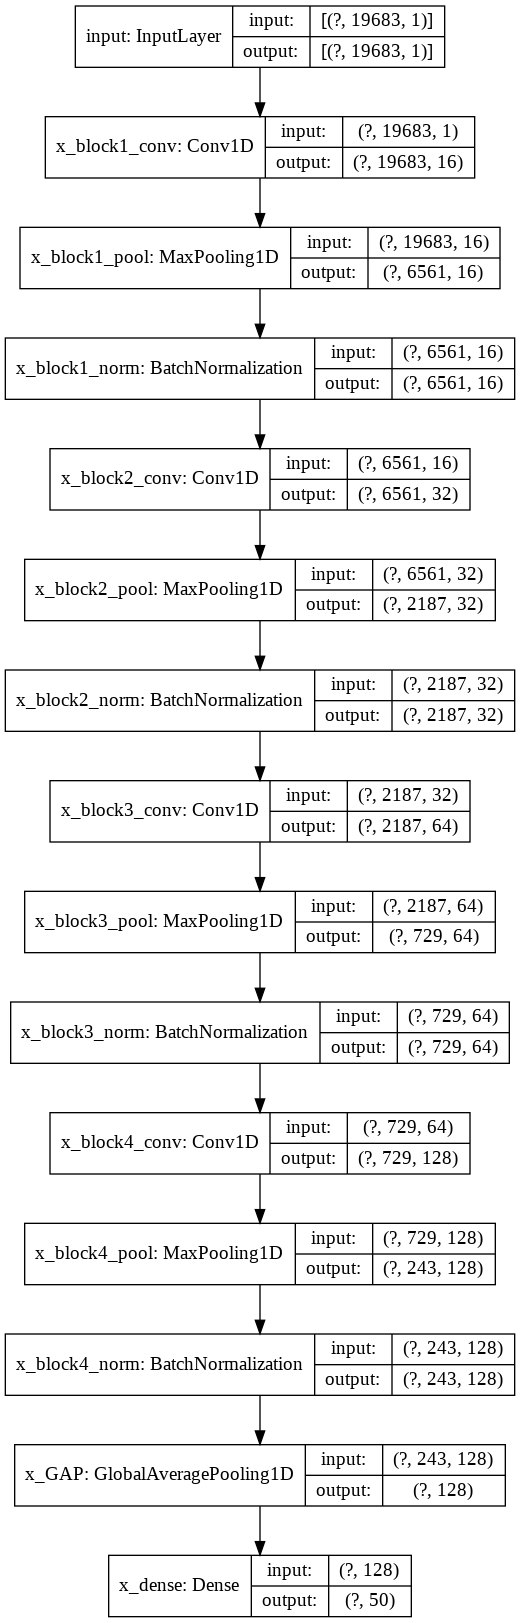

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(raw_audio_conv1d_model, show_shapes = True, to_file = 'raw_audio_conv1d_model.png')

In [0]:
pre_emp_audio_conv1d_model.summary()

Model: "20200509_pre_emp_audio_conv1d_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 19683, 1)]        0         
_________________________________________________________________
y_block1_pre_emp_conv (Conv1 (None, 19683, 1)          4         
_________________________________________________________________
y_block1_pool (MaxPooling1D) (None, 6561, 1)           0         
_________________________________________________________________
y_block1_norm (BatchNormaliz (None, 6561, 1)           4         
_________________________________________________________________
y_block2_conv (Conv1D)       (None, 6561, 32)          128       
_________________________________________________________________
y_block2_pool (MaxPooling1D) (None, 2187, 32)          0         
_________________________________________________________________
y_block2_norm (BatchNormaliz (N

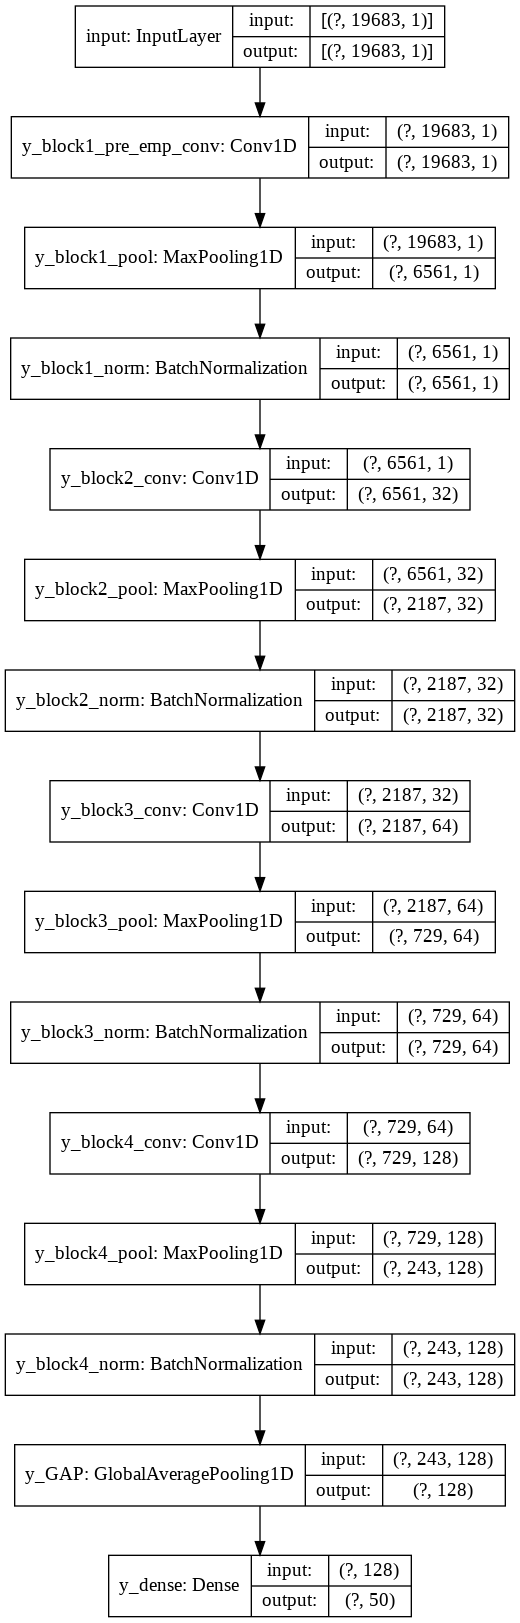

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(pre_emp_audio_conv1d_model, show_shapes = True, to_file = 'pre_emp_audio_conv1d_model.png')

**Train model**

In [0]:
import time

def compile_and_train(model, batch_size, epochs): 
    # compile
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    # train & validate
    print("Train on {} samples, validate on {} samples...".format(x_train.shape[0], x_val.shape[0]))

    start = time.time()
    print("[  start time] {}".format(time.strftime('%c', time.localtime(time.time()))))
    history = model.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 0)
    end = time.time()
    print("[    end time] {}".format(time.strftime('%c', time.localtime(time.time()))))
    print("[working time] {:.2f} (sec)".format(end - start))

    # save model & results
    save_model_path = "/content/drive/My Drive/models"
    save_results_path = "/content/drive/My Drive/results"

    if not os.path.exists(save_model_path):     os.mkdir(save_model_path)
    if not os.path.exists(save_results_path):   os.mkdir(save_results_path)

    model.save(os.path.join(save_model_path, model.name) + ".h5")
    np.savez_compressed(os.path.join(save_results_path, "{}_{}".format(notebookName, model.name)),
                        accuracy = history.history['accuracy'],
                        val_accuracy = history.history['val_accuracy'],
                        loss = history.history['loss'],
                        val_loss = history.history['val_loss'])
    
    return history

In [0]:
batch_size = 80
epochs = 500

In [0]:
history1 = compile_and_train(raw_audio_conv1d_model, batch_size = batch_size, epochs = epochs)

Train on 3200 samples, validate on 800 samples...
[  start time] Sat May  9 06:50:31 2020
[    end time] Sat May  9 07:20:03 2020
[working time] 1771.94 (sec)


In [0]:
history2 = compile_and_train(pre_emp_audio_conv1d_model, batch_size = batch_size, epochs = epochs)

Train on 3200 samples, validate on 800 samples...
[  start time] Sat May  9 07:20:03 2020
[    end time] Sat May  9 07:39:21 2020
[working time] 1157.68 (sec)


**히스토리 출력**

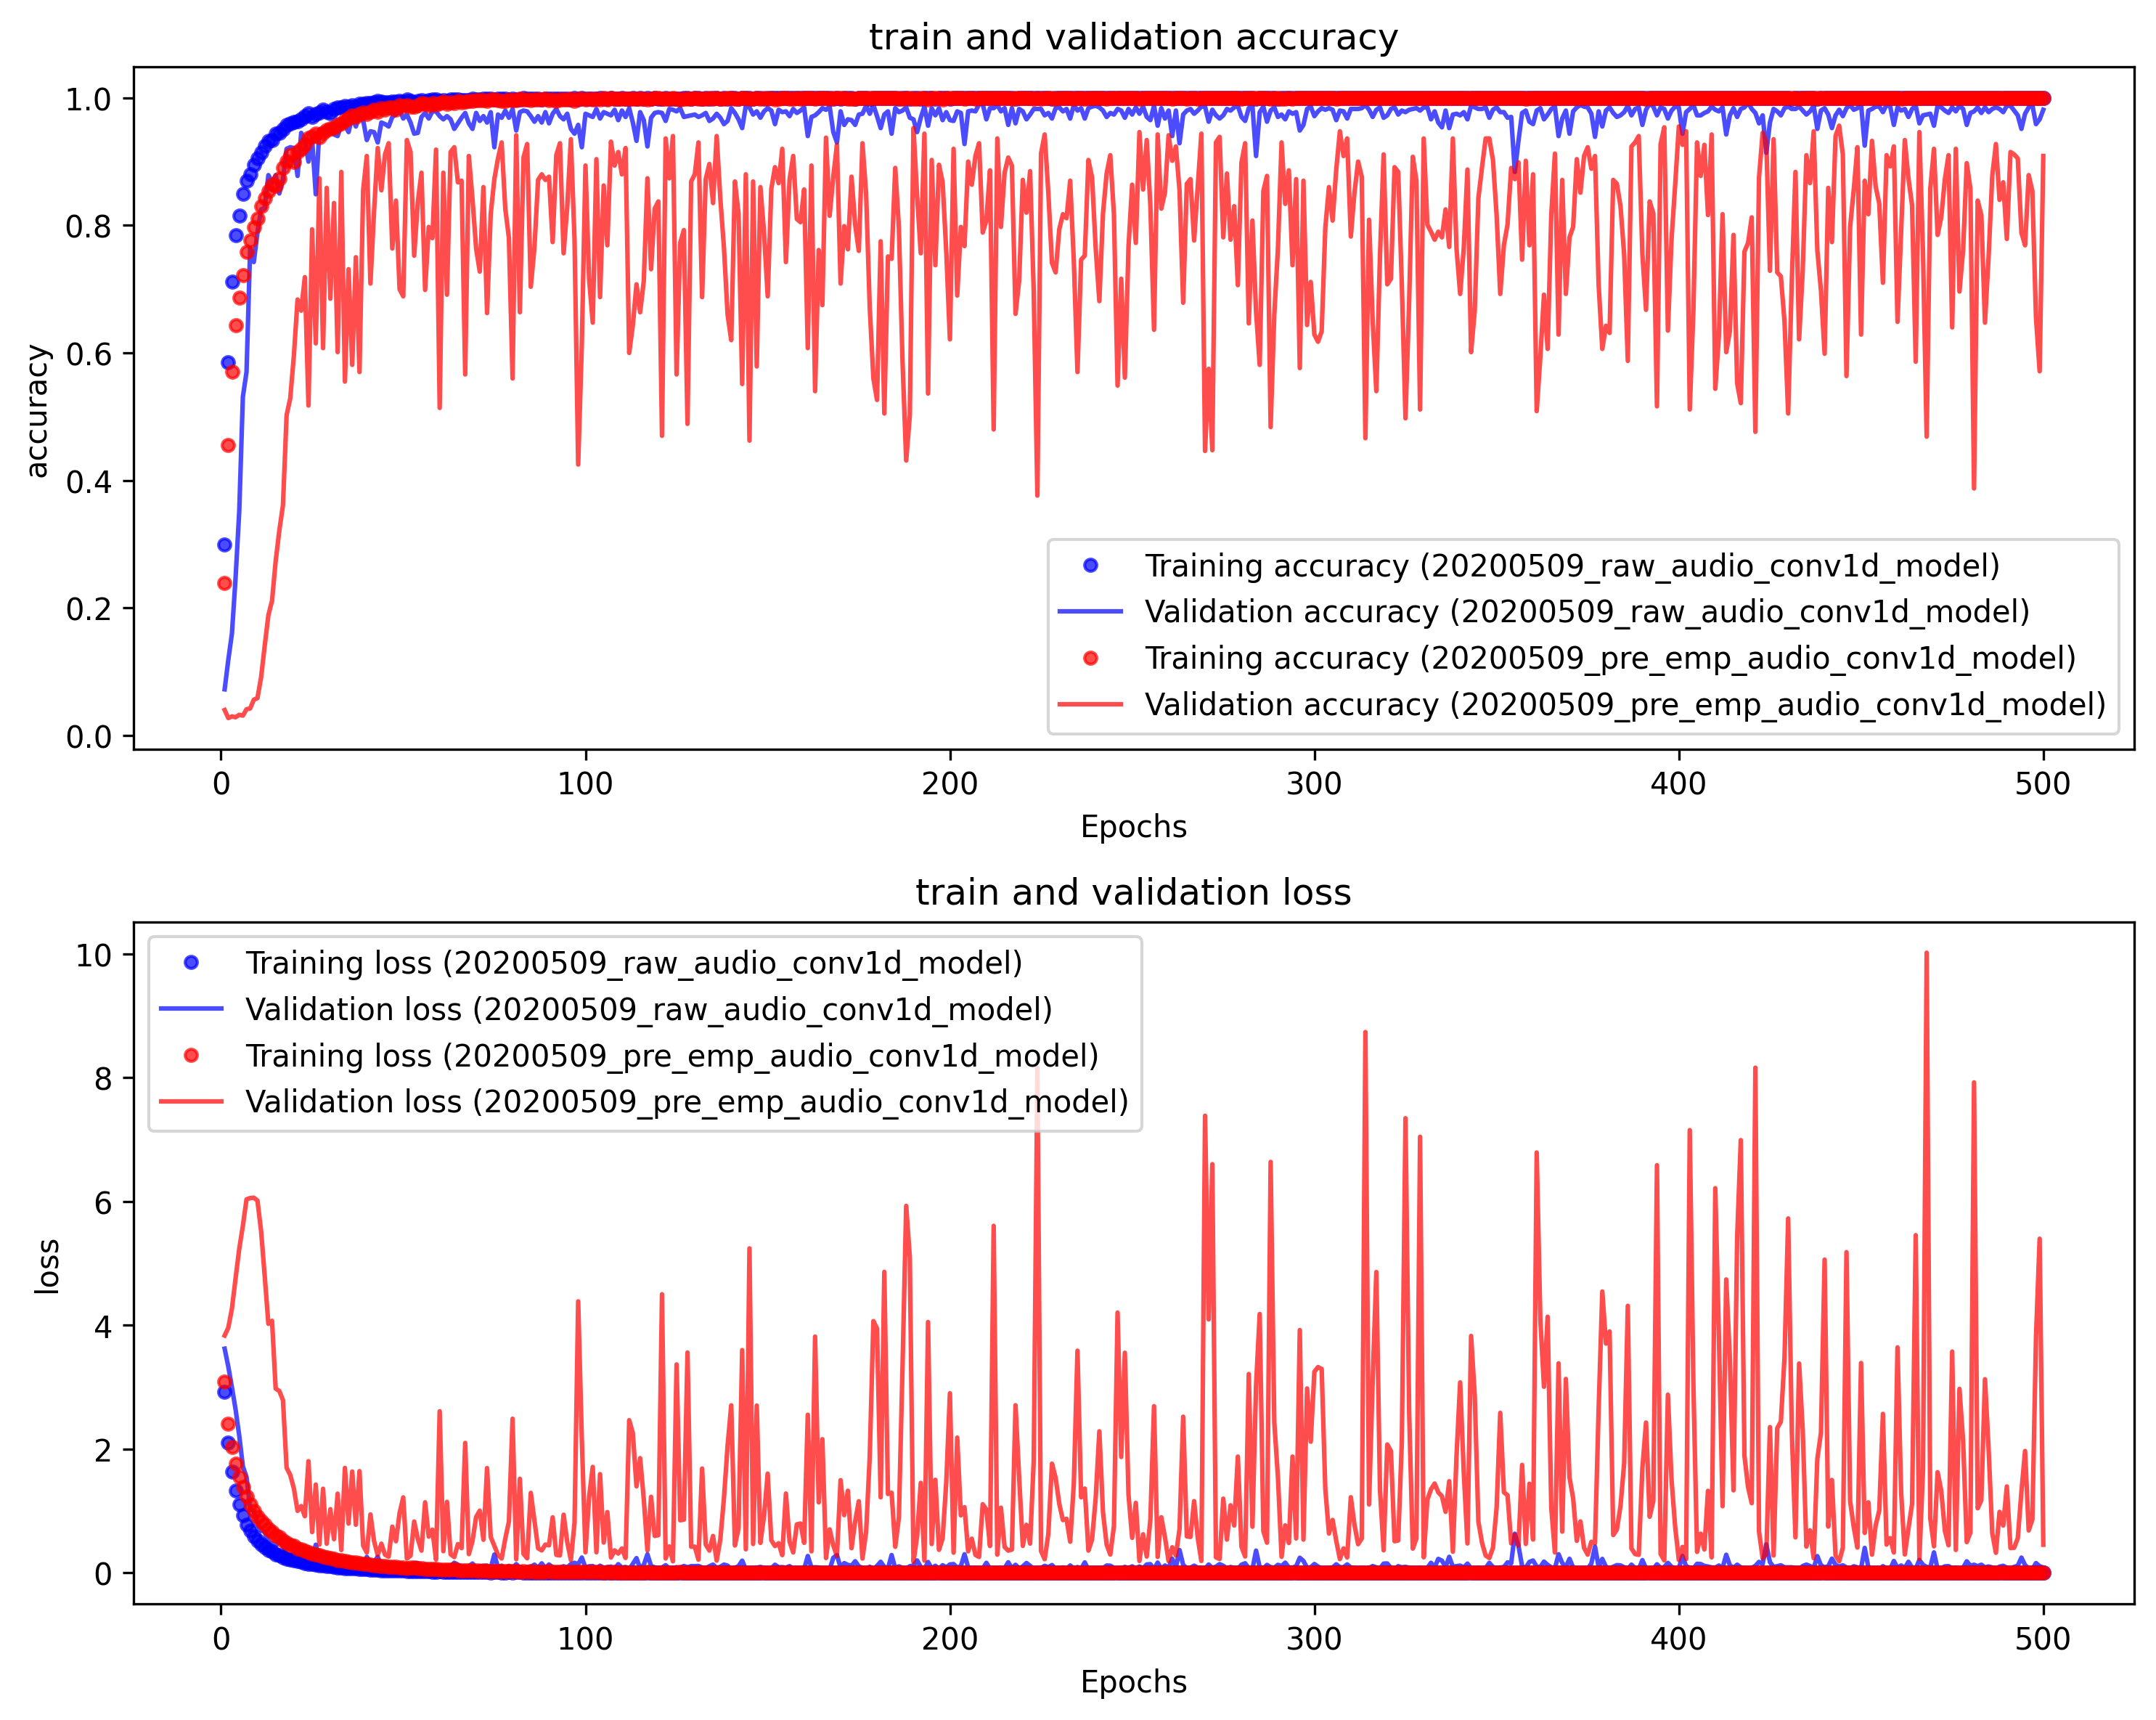

In [0]:
import matplotlib.pyplot as plt

acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

fig = plt.figure(figsize = (10, 8), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(2, 1, 1)

plt.plot(np.arange(1, len(acc1) + 1, 1), acc1, 'bo', ms = 4, alpha = .7,
         label = 'Training accuracy ({})'.format(raw_audio_conv1d_model.name))
plt.plot(np.arange(1, len(val_acc1) + 1, 1), val_acc1, 'b', alpha = .7,
         label = 'Validation accuracy ({})'.format(raw_audio_conv1d_model.name))
plt.plot(np.arange(1, len(acc2) + 1, 1), acc2, 'ro', ms = 4, alpha = .7,
         label = 'Training accuracy ({})'.format(pre_emp_audio_conv1d_model.name))
plt.plot(np.arange(1, len(val_acc2) + 1, 1), val_acc2, 'r', alpha = .7,
         label = 'Validation accuracy ({})'.format(pre_emp_audio_conv1d_model.name))
plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(2, 1, 2)

plt.plot(np.arange(1, len(loss1) + 1, 1), loss1, 'bo', ms = 4, alpha = .7,
         label = 'Training loss ({})'.format(raw_audio_conv1d_model.name))
plt.plot(np.arange(1, len(val_loss1) + 1, 1), val_loss1, 'b', alpha = .7,
         label = 'Validation loss ({})'.format(raw_audio_conv1d_model.name))
plt.plot(np.arange(1, len(loss2) + 1, 1), loss2, 'ro', ms = 4, alpha = .7,
         label = 'Training loss ({})'.format(pre_emp_audio_conv1d_model.name))
plt.plot(np.arange(1, len(val_loss2) + 1, 1), val_loss2, 'r', alpha = .7,
         label = 'Validation loss ({})'.format(pre_emp_audio_conv1d_model.name))
plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

**field test**

In [0]:
# reshaping
del test_data, test_labels

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

test_data = test_data.reshape(len(test_data), data_length, 1)
test_labels = to_categorical(test_labels)

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 19683, 1), test_labels.shape: (1000, 50)


In [0]:
results_1 = raw_audio_conv1d_model.evaluate(test_data, test_labels, batch_size = batch_size)
print('test1 loss, test1 acc:', results_1)

results_2 = pre_emp_audio_conv1d_model.evaluate(test_data, test_labels, batch_size = batch_size)
print('test2 loss, test2 acc:', results_2)

13/13 [==============================] - 0s 29ms/step - loss: 0.0808 - accuracy: 0.9840
test1 loss, test1 acc: [0.08076247572898865, 0.984000027179718]
13/13 [==============================] - 0s 19ms/step - loss: 0.3605 - accuracy: 0.9320
test2 loss, test2 acc: [0.3605344593524933, 0.9319999814033508]


**초기 설정했던 pre-emphasis의 가중치 변화 확인**

*   weight: [-0.97, 1] → [-1.02, 0.97]
*   bias: [0] → [1.94]

In [0]:
pre_emp_audio_conv1d_model.layers[1].get_weights()

[array([[[-1.0232347 ]],
 
        [[ 0.9707474 ]],
 
        [[-0.36549082]]], dtype=float32), array([1.9405911], dtype=float32)]

**두 모델의 output을 결합한 모델 앙상블(model essenble) 정의**

In [0]:
def ensemble_with_average(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = layers.Average(name = 'averaged')(outputs)
    
    model = Model(model_input, y, name = 'ensemble_with_average')
    return model

In [0]:
def ensemble_with_maximum(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = layers.Maximum(name = 'maximized')(outputs)
    
    model = Model(model_input, y, name = 'ensemble_with_maximum')
    return model

In [0]:
def evaluate_accuracy(model):
    pred = model.predict(test_data, batch_size = batch_size)
    pred = np.argmax(pred, axis = 1)
    accuracy = np.sum(np.equal(pred, np.argmax(test_labels, axis = 1))) / test_labels.shape[0]
    return accuracy

In [0]:
def evaluate_error(model):
    pred = model.predict(test_data, batch_size = batch_size)
    pred = np.argmax(pred, axis = 1)
    error = np.sum(np.not_equal(pred, np.argmax(test_labels, axis = 1))) / test_labels.shape[0]
    return error

In [0]:
models = [raw_audio_conv1d_model, pre_emp_audio_conv1d_model]

ensemble_with_average_model = ensemble_with_average(models, model_input)
ensemble_with_maximum_model = ensemble_with_maximum(models, model_input)

In [0]:
print(evaluate_accuracy(ensemble_with_average_model), evaluate_error(ensemble_with_average_model))

0.983 0.017


In [0]:
print(evaluate_accuracy(ensemble_with_maximum_model), evaluate_error(ensemble_with_maximum_model))

0.982 0.018
